In [1]:
import glob
import itertools
import lzma
import pickle as pkl
import pathlib
import os
import sys
from functools import lru_cache

import numpy as np
import pandas as pd
import plotly.express as px
from pubmedpy.eutilities import esearch_query, download_pubmed_ids
from tqdm import tqdm
from plotnine import *


sys.path.append('../indices')
from utils import parse_metadata

In [2]:
def calculate_percentiles(true_vals, doi_to_shuffled_metrics):
    dois, pageranks = [], []
    for doi, pagerank in true_vals.items():
        if pagerank is not None:
            dois.append(doi)
            pageranks.append(pagerank)
            
    percentiles = []
    for doi in dois:
        shuffled_metrics = doi_to_shuffled_metrics[doi]
        # If the node is unshuffleable for some reason, its percentile isn't meaningful
        if len(set(shuffled_metrics)) == 1:
            percentiles.append(None)
            continue
        true_val = true_vals[doi]
    
        percentile = np.searchsorted(shuffled_metrics, true_val) / 100
        percentiles.append(percentile)

    result_df = pd.DataFrame({'doi': dois, 'pagerank': pageranks, 'percentile': percentiles})
    return result_df

In [3]:
#@lru_cache(2)
def load_single_heading(heading_str):
    heading_shuffled = glob.glob(f'../output/shuffle_results/{heading_str}*-pagerank.pkl')

    doi_to_shuffled_metrics = {}

    for path in heading_shuffled:
        with open(path, 'rb') as in_file:
            result = pkl.load(in_file)
            for doi, value in result.items():
                if doi in doi_to_shuffled_metrics:
                    doi_to_shuffled_metrics[doi].append(value)
                else:
                    doi_to_shuffled_metrics[doi] = [value]
    for doi, vals in doi_to_shuffled_metrics.items():
        doi_to_shuffled_metrics[doi] = sorted(vals)
    
    with open(f'../output/{heading_str}-pagerank.pkl', 'rb') as in_file:
        true_vals = pkl.load(in_file)
        
    heading_df = calculate_percentiles(true_vals, doi_to_shuffled_metrics)
    return heading_df

def load_pair_headings(heading1, heading2):
    heading1_df = load_single_heading(f'{heading1}-{heading2}')
    heading2_df = load_single_heading(f'{heading2}-{heading1}')

    merged_df = heading1_df.merge(heading2_df, on='doi')
    merged_df = merged_df.rename({'pagerank_x': f'{heading1}_pagerank', 'pagerank_y': f'{heading2}_pagerank',
                                  'percentile_x': f'{heading1}_percentile', 'percentile_y': f'{heading2}_percentile'}, 
                                 axis='columns')
    merged_df[f'{heading1}-{heading2}'] = merged_df[f'{heading1}_percentile'] - merged_df[f'{heading2}_percentile']
    
    metadata_df = parse_metadata(f'../data/pubmed/efetch/{heading1}.xml.xz')
    full_df = merged_df.merge(metadata_df, on='doi')
    
    return full_df

### Load networks to look at overlap

In [4]:
in_files = glob.glob('../data/pubmed/efetch/*.xz')
in_files

['../data/pubmed/efetch/consumer_health_informatics.xml.xz',
 '../data/pubmed/efetch/photobiology.xml.xz',
 '../data/pubmed/efetch/developmental_biology.xml.xz',
 '../data/pubmed/efetch/laboratory_animal_science.xml.xz',
 '../data/pubmed/efetch/zoology.xml.xz',
 '../data/pubmed/efetch/botany.xml.xz',
 '../data/pubmed/efetch/nursing_informatics.xml.xz',
 '../data/pubmed/efetch/ecology.xml.xz',
 '../data/pubmed/efetch/latent_class_analysis.xml.xz',
 '../data/pubmed/efetch/dental_informatics.xml.xz',
 '../data/pubmed/efetch/exobiology.xml.xz',
 '../data/pubmed/efetch/cheminformatics.xml.xz',
 '../data/pubmed/efetch/microbiology.xml.xz',
 '../data/pubmed/efetch/parasitology.xml.xz',
 '../data/pubmed/efetch/cellular_automata.xml.xz',
 '../data/pubmed/efetch/sociobiology.xml.xz',
 '../data/pubmed/efetch/radiobiology.xml.xz',
 '../data/pubmed/efetch/synthetic_biology.xml.xz',
 '../data/pubmed/efetch/computational_biology.xml.xz',
 '../data/pubmed/efetch/medical_informatics.xml.xz',
 '../data/

In [5]:
heading_to_df = {}
for file in tqdm(in_files):
    heading = os.path.basename(file)
    heading = heading.split('.')[0]
    try:
        heading_to_df[heading] = parse_metadata(file)
    except:
        continue


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:15<00:00,  1.77it/s]


In [6]:
pairwise_data = {'heading1': [], 'heading2': [], 'paper_overlap': [],
                 'overlap_count': []}
for heading1, heading2 in tqdm(itertools.combinations(sorted(list(heading_to_df.keys())), 2), total=378):
    heading1_df = heading_to_df[heading1]
    heading2_df = heading_to_df[heading2]
    heading1_dois = set(heading1_df['doi'])
    heading2_dois = set(heading2_df['doi'])
    union = heading1_dois | heading2_dois
    intersection = heading1_dois & heading2_dois
    paper_overlap = len(intersection) / len(union)
    overlap_count = len(intersection)
    
    pairwise_data['paper_overlap'].append(paper_overlap)
    pairwise_data['heading1'].append(heading1)
    pairwise_data['heading2'].append(heading2)
    pairwise_data['overlap_count'].append(overlap_count)

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 351/378 [00:04<00:00, 84.26it/s]


In [7]:
pairwise_df = pd.DataFrame(pairwise_data)
pairwise_df

,heading1,heading2,paper_overlap,overlap_count
0,artificial_intelligence,botany,0.000139,18
1,artificial_intelligence,cell_biology,0.000133,17
2,artificial_intelligence,cellular_automata,0.000016,2
3,artificial_intelligence,cheminformatics,0.000472,59
4,artificial_intelligence,computational_biology,0.035020,11541
...,...,...,...,...
346,radiobiology,synthetic_biology,0.000174,1
347,radiobiology,zoology,0.000239,1
348,sociobiology,synthetic_biology,0.000245,1
349,sociobiology,zoology,0.000397,1


In [8]:
headings1 = set(pairwise_df[pairwise_df['overlap_count'] > 1000]['heading1'])
headings2 = set(pairwise_df[pairwise_df['overlap_count'] > 1000]['heading2']) 
pairwise_df = pairwise_df[pairwise_df['heading1'].isin(headings1 | headings2)]
pairwise_df = pairwise_df[pairwise_df['heading2'].isin(headings1 | headings2)]

In [9]:
pairwise_df['log_overlap_count'] = np.log(pairwise_df['overlap_count'])
pairwise_df['log_overlap'] = np.log(pairwise_df['paper_overlap'])

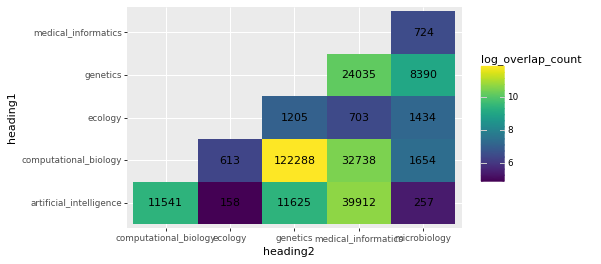

<ggplot: (8786205849549)>

In [10]:
plot = ggplot(pairwise_df, aes(x='heading2', y='heading1', fill='log_overlap_count', label='overlap_count'))
plot += geom_tile()
plot += geom_text()
plot

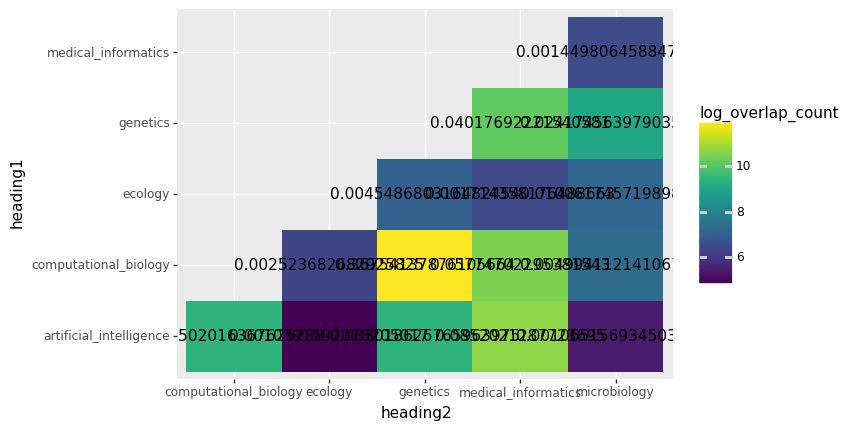

<ggplot: (8785947703197)>

In [11]:
plot = ggplot(pairwise_df, aes(x='heading2', y='heading1', fill='log_overlap_count', label='paper_overlap'))
plot += geom_tile()
plot += geom_text()
plot

### Let's calculate correlations

In [12]:
headings = ["artificial_intelligence", "computational_biology", 
            "ecology", "genetics", "medical_informatics", "microbiology"]
            

pairwise_data = {'percentile_correlation': [], 'pagerank_correlation': [],
                 'heading1': [], 'heading2': [], 'paper_overlap': [],
                 'overlap_count': []}
for heading1, heading2 in tqdm(itertools.combinations(sorted(headings), 2)):
    heading1_df = load_single_heading(f'{heading1}-{heading2}')
    heading2_df = load_single_heading(f'{heading2}-{heading1}')
    
    heading1_dois = set(heading1_df['doi'])
    heading2_dois = set(heading2_df['doi'])
    union = heading1_dois | heading2_dois
    intersection = heading1_dois & heading2_dois
    paper_overlap = len(intersection) / len(union)
    overlap_count = len(intersection)
    
    merged_df = load_pair_headings(heading1, heading2)
    
    percentile_correlation = merged_df[f'{heading1}_percentile'].corr(merged_df[f'{heading2}_percentile'])
    pagerank_correlation = merged_df[f'{heading1}_pagerank'].corr(merged_df[f'{heading2}_pagerank'])
    
    pairwise_data['percentile_correlation'].append(percentile_correlation)
    pairwise_data['pagerank_correlation'].append(pagerank_correlation)
    pairwise_data['paper_overlap'].append(paper_overlap)
    pairwise_data['heading1'].append(heading1)
    pairwise_data['heading2'].append(heading2)
    pairwise_data['overlap_count'].append(overlap_count)

15it [09:29, 37.98s/it]


In [13]:
merged_df

,doi,medical_informatics_pagerank,medical_informatics_percentile,microbiology_pagerank,microbiology_percentile,medical_informatics-microbiology,pmid,pmcid,journal,journal_nlm_id,title,publication_date,authors
0,10.1089/fpd.2010.0787,0.000002,1.00,0.000035,0.03,0.97,21492021,None,Foodborne Pathog Dis,101120121,Global monitoring of Salmonella serovar distri...,2011-04-14,"[{'fore_name': 'Rene S', 'last_name': 'Hendrik..."
1,10.1099/mic.0.034793-0,0.000004,0.08,0.000013,0.26,-0.18,19910409,None,Microbiology (Reading),9430468,Integrating multiple 'omics' analysis for micr...,2009-11-12,"[{'fore_name': 'Weiwen', 'last_name': 'Zhang',..."
2,10.1146/annurev.publhealth.24.012902.141019,0.000008,0.23,0.000003,1.00,-0.77,12668753,None,Annu Rev Public Health,8006431,GIS and disease.,2002-10-23,"[{'fore_name': 'Ellen K', 'last_name': 'Cromle..."
3,10.1007/s10916-009-9302-9,0.000002,0.99,0.000003,1.00,-0.01,20703621,None,J Med Syst,7806056,A decision support system for preventing Legio...,2009-05-15,"[{'fore_name': 'Oya H', 'last_name': 'Yüregir'..."
4,10.1093/nar/gkj076,0.000010,0.78,0.000011,0.32,0.46,16381924,PMC1347439,Nucleic Acids Res,0411011,The University of Minnesota Biocatalysis/Biode...,2006-01-01,"[{'fore_name': 'Lynda B M', 'last_name': 'Elli..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,10.1128/microbiolspec.emf-0005-2015,0.000001,1.00,0.000003,1.00,0.00,27726816,None,Microbiol Spectr,101634614,Statistical Considerations in Environmental Mi...,2016-08,"[{'fore_name': 'Graham', 'last_name': 'McBride..."
441,10.1093/nar/gkab815,0.000001,1.00,0.000004,0.97,0.03,34614189,PMC8643649,Nucleic Acids Res,0411011,metaGEM: reconstruction of genome scale metabo...,2021-12-02,"[{'fore_name': 'Francisco', 'last_name': 'Zorr..."
442,10.1038/s41598-021-99196-x,0.000001,1.00,0.000003,1.00,0.00,34645885,PMC8514479,Sci Rep,101563288,Sulphate-reducing bacterial community structur...,2021-10-13,"[{'fore_name': 'Samyra Raquel Gonçalves', 'las..."
443,10.1038/s41586-021-04332-2,0.000001,1.00,0.000003,1.00,0.00,35082445,None,Nature,0410462,Petabase-scale sequence alignment catalyses vi...,2022-01-26,"[{'fore_name': 'Robert C', 'last_name': 'Edgar..."


In [14]:
correlation_df = pd.DataFrame(pairwise_data)
correlation_df['log_overlap_count'] = np.log(correlation_df['overlap_count'])
correlation_df['shortname'] = correlation_df['heading1'].str[:4] + '-' + correlation_df['heading2'].str[:4]
correlation_df

,percentile_correlation,pagerank_correlation,heading1,heading2,paper_overlap,overlap_count,log_overlap_count,shortname
0,0.699687,0.815397,artificial_intelligence,computational_biology,0.030411,8816,9.084324,arti-comp
1,0.177497,0.316312,artificial_intelligence,ecology,0.000654,78,4.356709,arti-ecol
2,0.644193,0.455296,artificial_intelligence,genetics,0.025441,7709,8.950144,arti-gene
3,0.575147,0.700498,artificial_intelligence,medical_informatics,0.080909,30607,10.328984,arti-medi
4,0.437282,0.238201,artificial_intelligence,microbiology,0.000862,176,5.170484,arti-micr
5,0.429313,0.407321,computational_biology,ecology,0.002125,453,6.115892,comp-ecol
6,0.897013,0.933085,computational_biology,genetics,0.382290,112008,11.626326,comp-gene
7,0.656889,0.682126,computational_biology,medical_informatics,0.061023,28939,10.272945,comp-medi
8,0.678349,0.801058,computational_biology,microbiology,0.004703,1398,7.242798,comp-micr
9,0.454318,0.294030,ecology,genetics,0.003754,844,6.738152,ecol-gene


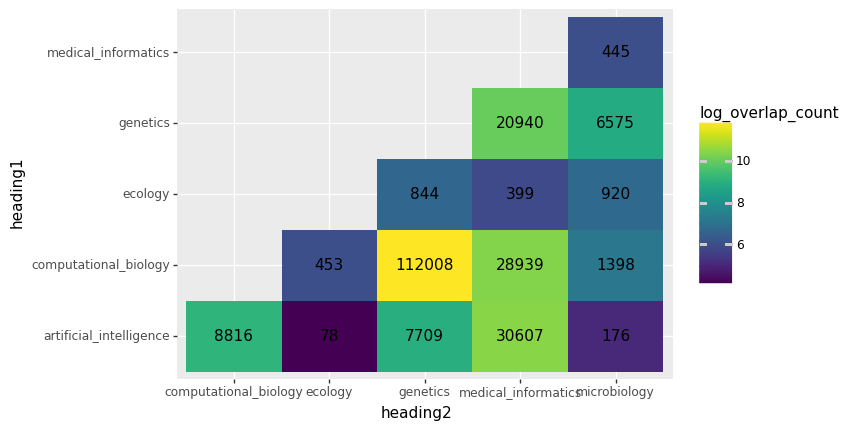

<ggplot: (8785947501367)>

In [15]:
# Make sure overlap looks the same
plot = ggplot(correlation_df, aes(x='heading2', y='heading1', fill='log_overlap_count', label='overlap_count'))
plot += geom_tile()
plot += geom_text()
plot

#### Result
Same trends, but smaller count; this may be due to the metric calculation removing the self loops and duplicate edges in the graph, but I'll have to check

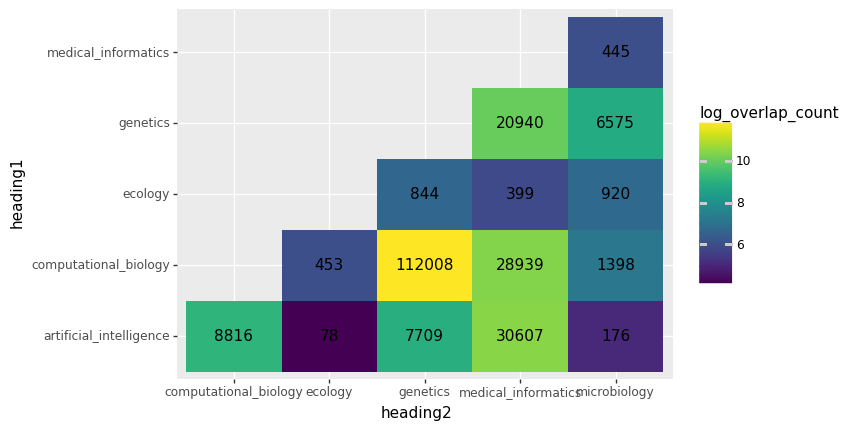

<ggplot: (8785947501148)>

In [16]:
plot = ggplot(correlation_df, aes(x='heading2', y='heading1', fill='log_overlap_count', label='overlap_count'))
plot += geom_tile()
plot += geom_text()
plot

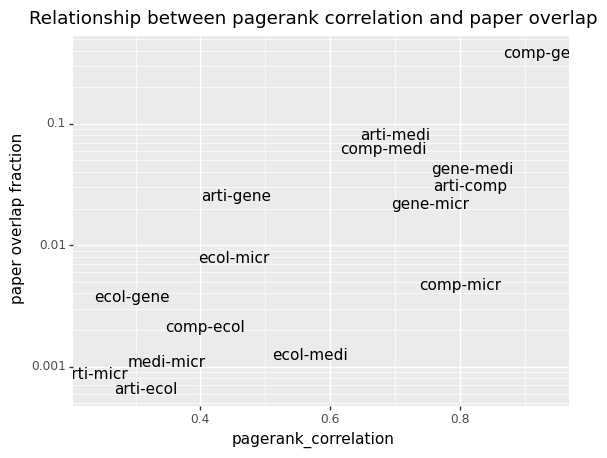

<ggplot: (8785947600215)>

In [17]:
# What is the relationship between the pagerank correlation and the percent overlap?
plot = ggplot(correlation_df, aes(x='pagerank_correlation', y='paper_overlap', label='shortname'))
plot += scale_y_log10()
plot += geom_text()
plot += ylab('paper overlap fraction')
plot += ggtitle('Relationship between pagerank correlation and paper overlap')
plot

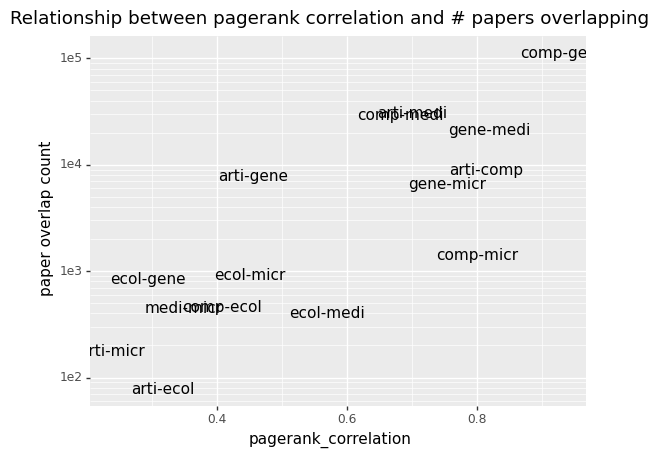

<ggplot: (8785947757626)>

In [18]:
# What is the relationship between the pagerank correlation and the percent overlap?
plot = ggplot(correlation_df, aes(x='pagerank_correlation', y='overlap_count', label='shortname'))
plot += scale_y_log10()
plot += geom_text()
plot += ylab('paper overlap count')
plot += ggtitle('Relationship between pagerank correlation and # papers overlapping')
plot

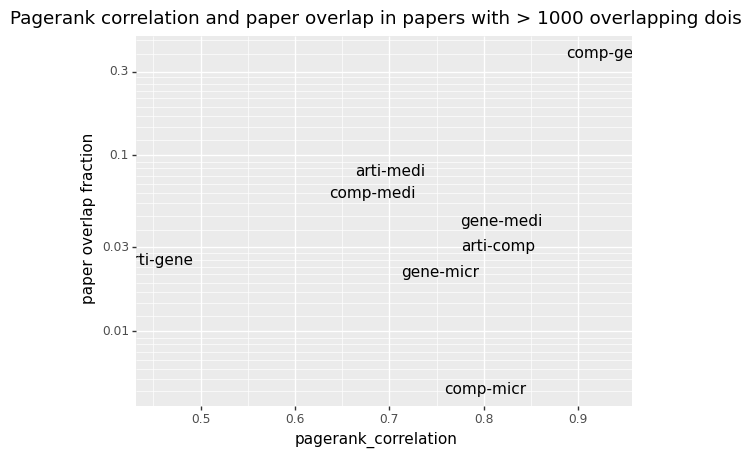

<ggplot: (8785856098416)>

In [19]:
# What is the relationship between the pagerank correlation and the percent overlap?
plot = ggplot(correlation_df[correlation_df['overlap_count'] > 1000], aes(x='pagerank_correlation', y='paper_overlap', label='shortname'))
plot += scale_y_log10()
plot += geom_text()
plot += ylab('paper overlap fraction')
plot += ggtitle('Pagerank correlation and paper overlap in papers with > 1000 overlapping dois')
plot

#### Result
Having more paper overlap tends to lead to a greater pagerank correlation, but the relationship isn't linear and there is a good amount of variance

This trend may not hold in fields with many overlapping papers though

## Remaining questions:

### Percentiles
Does the pagerank percentile measure something similar to pagerank correlation or paper overlap?

### What are the most similar papers in the most dissimilar fields?